<center><h1>Multinomial Classification of Interest Levels for RentHop.com Listings</h1></center>
<center><h3>Clarence Ngoh, Serene Gao</h3></center>
<br>
<center>May 11, 2017</center>
<hr>
<center><h3>Abstract</h3></center>
<p>
<a href="https://www.renthop.com"><strong>RentHop</strong></a> is a web and mobile-based search engine that allows users to search for rental housing in many major cities in the US. Created in February 2009 to solve the problem of hunting for a suitable apartment, RentHop has continually refined its sorting algorithm to allow users to search smarter - using data to sort rental listings by quality.
</p>
<p>
For our project, we make use of RentHop’s listing data hosted on <a href="https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries">Kaggle.com</a> to predict the interest level for new listings, given publicly available attributes of current listings. We are motivated by the potential to uncover business value as the results can help agents better understand renters’ needs and preferences. Furthermore, given the highly competitive business landscape of apartment rental websites, it is crucial that Renthop is able to leverage machine learning to find out what features are the most important to users. This will greatly supplement the existing "Hopscore" that they have created to rank search results by relevance. 
</p>
<br>
<br>

<center><h3>Exploratory Data Analysis</h3></center>

In [224]:
# importing required dependencies
import pandas as pd
import numpy as np

# visualisation 
from IPython.display import display
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# import sklearn dependencies
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# others
import geocoder as geo

In [225]:
# loading dataset
train = pd.read_json('train.json')

### Basic 

Let's first look at the some basic attributes of our dataset.

In [226]:
# size of the dataset
train.shape

(49352, 15)

In [227]:
# show the available features
train.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'interest_level', 'latitude',
       'listing_id', 'longitude', 'manager_id', 'photos', 'price',
       'street_address'],
      dtype='object')

In [228]:
# get a sense of the format of the data
train.head().T

,10,10000,100004,100007,100013
bathrooms,1.5,1,1,1,1
bedrooms,3,2,1,1,4
building_id,53a5b119ba8f7b61d4e010512e0dfc85,c5c8a357cba207596b04d1afd1e4f130,c3ba40552e2120b0acfc3cb5730bb2aa,28d9ad350afeaab8027513a3e52ac8d5,0
created,2016-06-24 07:54:24,2016-06-12 12:19:27,2016-04-17 03:26:41,2016-04-18 02:22:02,2016-04-28 01:32:41
description,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,,"Top Top West Village location, beautiful Pre-w...",Building Amenities - Garage - Garden - fitness...,Beautifully renovated 3 bedroom flex 4 bedroom...
display_address,Metropolitan Avenue,Columbus Avenue,W 13 Street,East 49th Street,West 143rd Street
features,[],"[Doorman, Elevator, Fitness Center, Cats Allow...","[Laundry In Building, Dishwasher, Hardwood Flo...","[Hardwood Floors, No Fee]",[Pre-War]
interest_level,medium,low,high,low,low
latitude,40.7145,40.7947,40.7388,40.7539,40.8241
listing_id,7211212,7150865,6887163,6888711,6934781


In [229]:
# Get statistical summary of the numerical features
train.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


### Target Variable Analysis

Here, we focus on the target variable, which is the interest_level that we want to predict. 

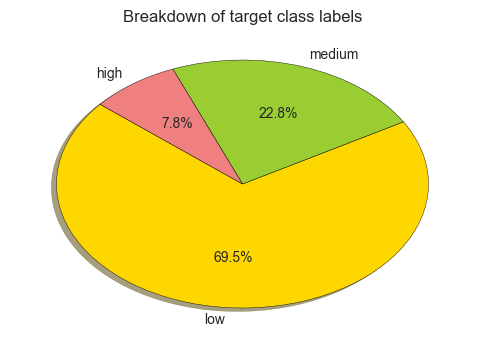

In [230]:
# lets look at the distribution of the different target classes within the training dataset
class_sizes = train['interest_level'].value_counts().values
labels = ['low', 'medium', 'high']
colors = ['gold', 'yellowgreen', 'lightcoral']
plt.pie(class_sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Breakdown of target class labels")
plt.show()

We can observe class imbalance within the training set, where the 3 interest_levels are not represented equally. This could mean that our predicted results are only valid with the underlying distribution, affecting the ability of our model to generalised to other datasets. 

### Extreme Value Analysis

In this section, we want to look at the distribution of numerical variables, paying special attention to the presence of any outliers that we can remove before training the model. Doing this step first will help us reduce noise.

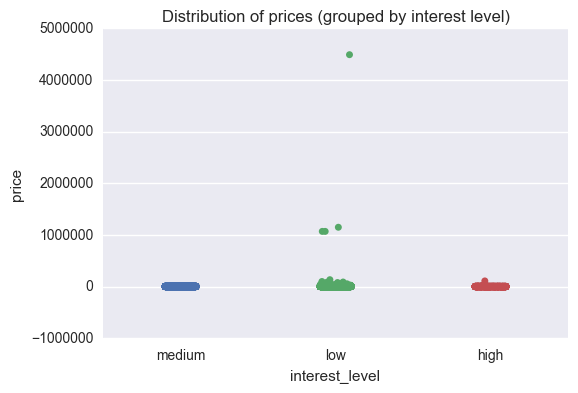

In [231]:
sns.stripplot(train['interest_level'], train['price'], jitter=True)
plt.title('Distribution of prices (grouped by interest level)')
plt.show()

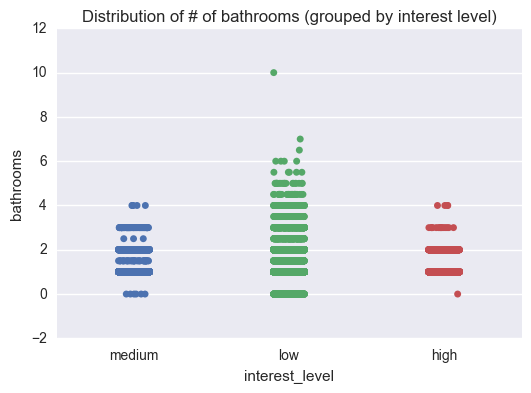

In [232]:
sns.stripplot(train['interest_level'], train['bathrooms'], jitter=True)
plt.title('Distribution of # of bathrooms (grouped by interest level)')
plt.show()

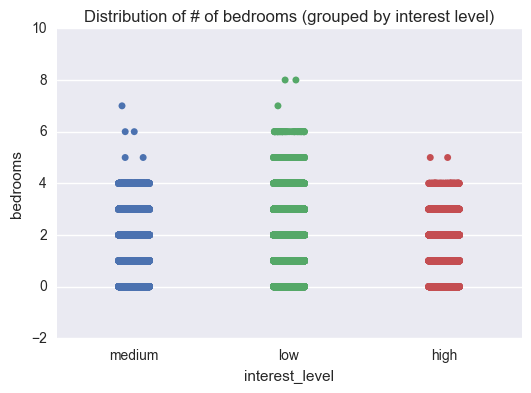

In [233]:
sns.stripplot(train['interest_level'], train['bedrooms'], jitter=True)
plt.title('Distribution of # of bedrooms (grouped by interest level)')
plt.show()

From the above scatter plots, we already observe outliers that can be removed! For example, there is a single listing with 10 bathrooms, and another with a price tag of almost $5m. 

In [234]:
# removing the outliers from the data
train = train[train['price'] < np.percentile(train.price.values, 99)] # remove price outliers
train = train[train['bathrooms'] < 10] # remove bathroom outlier

<center><h3>Baseline Model</h3></center>

Let's build a baseline model with the minimal amount of preparation we have done with the dataset. This will allow us to evaluate further actions against. We will only consider the numerical features for now.

To evaluate our model, we will use the multiclass logarithmic loss metric. This metric quantifies the accuracy of the classifier by penalizing false classifications, especially so if it was predicted at high confidence. The lower the log loss score, the better. A low log loss score is thus indicative of a robust model, and is well suited for multinomial classification problems. We will also output the accuracy score as well for comparison.

In [235]:
# lets first define a helper function that will help us evaluate our model against a few metrics
def evaluate(clf, X_test, Y_test, clf_name):
    print("===== {} =====".format(clf_name))
    
    print("Number of features = {}\n".format(X_test.shape[1]))
    
    predicted = clf.predict(X_test)
    predicted_prob = clf.predict_proba(X_test)
    
    print("Accuracy: {}".format(accuracy_score(Y_test, predicted)))
    print("Log Loss: {}".format(log_loss(Y_test, predicted_prob)))
    labels = ['low', 'medium', 'high']

    print("Confusion Matrix:")
    display(pd.DataFrame(data=confusion_matrix(Y_test, predicted, labels=['low', 'medium', 'high']), index=labels, columns=labels))
    
    print("Report:")
    print(classification_report(Y_test, predicted))

In [236]:
# extract X and Y
y_train = train['interest_level'].values
x_train = train[['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price']] # use only numerical features

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "Baseline Model (numerical features only)")

===== Baseline Model (numerical features only) =====
Number of features = 5

Accuracy: 0.6888433981576254
Log Loss: 2.972402736738308
Confusion Matrix:


,low,medium,high
low,5784,794,172
medium,1315,712,241
high,291,227,234


Report:
             precision    recall  f1-score   support

       high       0.36      0.31      0.33       752
        low       0.78      0.86      0.82      6750
     medium       0.41      0.31      0.36      2268

avg / total       0.66      0.69      0.67      9770



<center><h3>Feature Engineering</h3></center>

Now that we have a baseline model, we can start to explore the data again to see how we can extract other features, that can be used to improve our model to get better predictions.

### Derived Features

We can do some simple aggregation on existing fields that give us new numerical features that are meaningful for our model.

In [237]:
# price per bedroom
price_per_bedroom = train['price'] / train['bedrooms']
train1 = train.assign(price_per_bedroom=price_per_bedroom)

# price per bathroom
price_per_bathroom = train['price'] / train['bathrooms']
train1 = train1.assign(price_per_bathroom=price_per_bathroom)

# price per (bathroom + bedroom)
price_per_totalrooms = train['price'] / (train['bedrooms'] + train['bathrooms'])
train1 = train1.assign(price_per_totalrooms=price_per_totalrooms)

# number of features
train1 = train1.assign(num_features=[len(features) for features in train1['features'].values])

# number of characters in description
train1 = train1.assign(desc_length=[len(text) for text in train1['description'].values])

While we are not using any form of image recognition in our model just yet, our intuition is that the number of photos that a listing has should also affect its interest level. Let's make that into a feature too.

In [238]:
# number of photos
train1 = train1.assign(num_photos=[len(photos) for photos in train1['photos'].values])

In [239]:
# make sure there are no NA values as a result
train1.replace([np.inf, -np.inf], np.nan, inplace=True)
train1.dropna(axis=0, inplace=True, subset=['price_per_bedroom', 'price_per_bathroom', 'price_per_totalrooms'])

In [240]:
# preview of the derived features
train1.head(3).T

,10,10000,100004
bathrooms,1.5,1,1
bedrooms,3,2,1
building_id,53a5b119ba8f7b61d4e010512e0dfc85,c5c8a357cba207596b04d1afd1e4f130,c3ba40552e2120b0acfc3cb5730bb2aa
created,2016-06-24 07:54:24,2016-06-12 12:19:27,2016-04-17 03:26:41
description,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,,"Top Top West Village location, beautiful Pre-w..."
display_address,Metropolitan Avenue,Columbus Avenue,W 13 Street
features,[],"[Doorman, Elevator, Fitness Center, Cats Allow...","[Laundry In Building, Dishwasher, Hardwood Flo..."
interest_level,medium,low,high
latitude,40.7145,40.7947,40.7388
listing_id,7211212,7150865,6887163


### Feature Discretization

There is a whole lot of data that we are ignoring when we only look at numerical features. One way to get more utility out of the data is to discretize some non-numerical features into classes. 

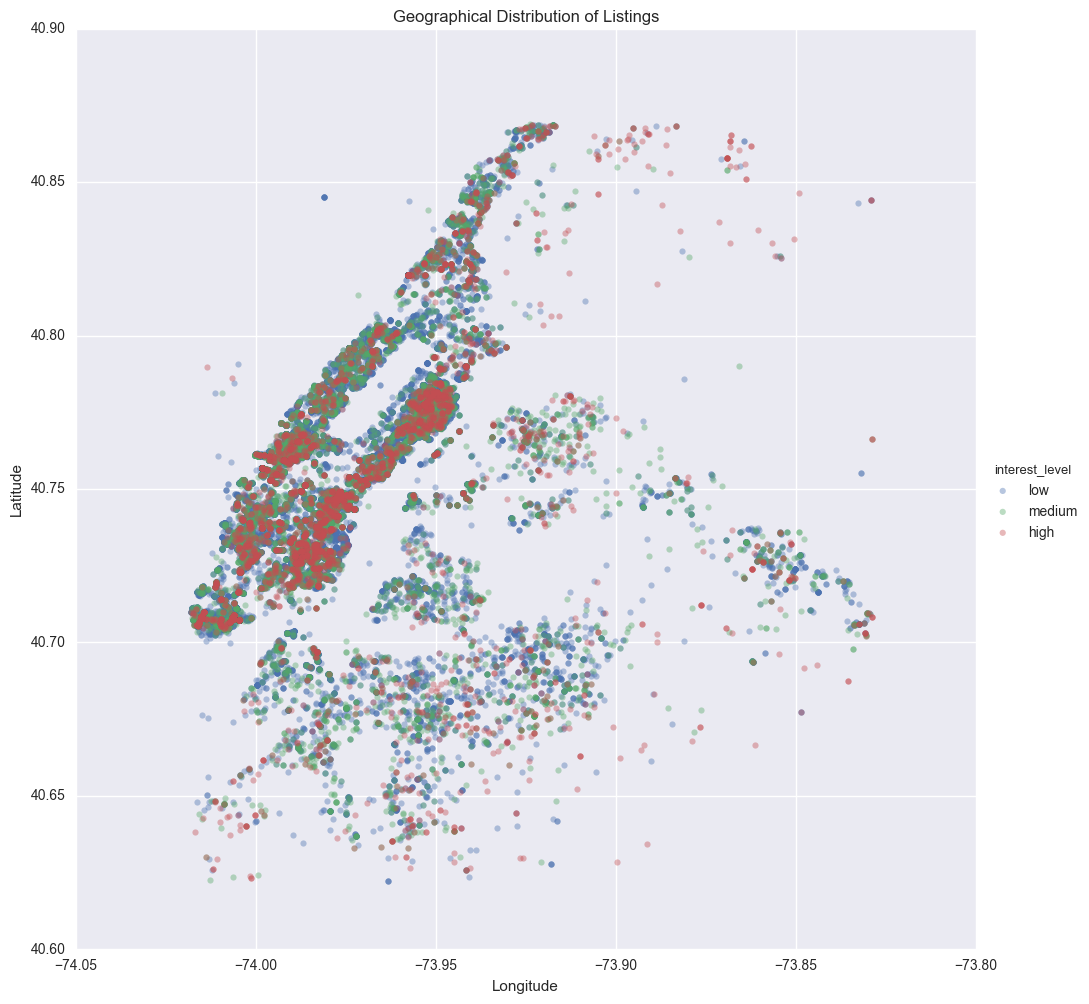

In [241]:
# first, we look at the location information (lat and lng)
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=10, scatter_kws={'alpha':0.4},
           data=train[(train.longitude>train.longitude.quantile(0.005)) # remove outliers so we can get a better view
                           &(train.longitude<train.longitude.quantile(0.995))
                           &(train.latitude>train.latitude.quantile(0.005))                           
                           &(train.latitude<train.latitude.quantile(0.995))])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Geographical Distribution of Listings")
plt.show()

There seems like there could be some clustering of high interest listings, which means that location could be a useful predictor. Instead of using the raw latitude/longitude values, we hypothesize that we can reduce noise and increase accuracy by looking up the exact neighborhood instead. We wrote the code to use Google Geocoding API to script this, but unfortunately, we were not able to include the neighborhood in the final model due to the rate limiting of the API to only 2000 calls per day. 

In [242]:
# add a new neighborhood column

def get_neighborhood(latlng):
    return
    res = geo.google(latlng.tolist(), method='reverse')
    return res.neighborhood    

# train.assign(neighborhood=[get_neighborhood(x) for x in train[['latitude', 'longitude']].values])
# commented out since geocoding API is rate limited, and we cannot query for all listings

We can also make use of `LabelBinarizer` to start making use of the categorical variables in our dataset to train the model. We will do this pre-processing step on building_id and manager_id. 

In [243]:
from sklearn import preprocessing
lb_managerid = preprocessing.LabelBinarizer()
lb_managerid.fit(train1['manager_id'])
lb_buildingid = preprocessing.LabelBinarizer()
lb_buildingid.fit(train1['building_id'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [244]:
managerids = pd.DataFrame(lb_managerid.transform(train1['manager_id']))
# rename the column / feature
managerids.columns = ['managerid_' + str(x) for x in managerids.columns]
buildingids = pd.DataFrame(lb_buildingid.transform(train1['building_id']))
buildingids.columns = ['buildingid_' + str(x) for x in buildingids.columns]

In [245]:
train1 = train1.reset_index() # so there are no problems concatenating
train1 = train1.drop('index', axis=1)
train1 = pd.concat([train1, managerids, buildingids], axis=1)

Let's see how our model improves now with after all these steps:

In [246]:
# extract X and Y
y_train = train1['interest_level'].values
x_train = train1.drop(['interest_level', 'manager_id', 'building_id','created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "Derived Features + Categorical Variables")

===== Derived Features + Categorical Variables =====
Number of features = 9998

Accuracy: 0.7303428061679623
Log Loss: 1.9602031594023221
Confusion Matrix:


,low,medium,high
low,5001,417,55
medium,1077,580,152
high,217,198,150


Report:
             precision    recall  f1-score   support

       high       0.42      0.27      0.33       565
        low       0.79      0.91      0.85      5473
     medium       0.49      0.32      0.39      1809

avg / total       0.70      0.73      0.71      7847



### Extracting Textual Features

This dataset is interesting because in addition to numerical features, we also have 2 fields with textual data. We shall visualize them to see if we can find a meaningful way to use them.

In [247]:
train['features'].values

array([[],
       ['Doorman', 'Elevator', 'Fitness Center', 'Cats Allowed', 'Dogs Allowed'],
       ['Laundry In Building', 'Dishwasher', 'Hardwood Floors', 'Pets Allowed Case by Case'],
       ...,
       ['Doorman', 'Elevator', 'Pre-War', 'Dogs Allowed', 'Cats Allowed'],
       ['Doorman', 'Elevator', 'Pre-War', 'Dogs Allowed', 'Cats Allowed'],
       ['Hardwood Floors']], dtype=object)

In [248]:
# accumulate word tokens from text fields
feature_arr = []
description_arr = []
for f in train['features'].values:
    feature_arr.extend([w.lower() for w in f])
for w in train['description'].values:
    description_arr.extend(w.lower().split())

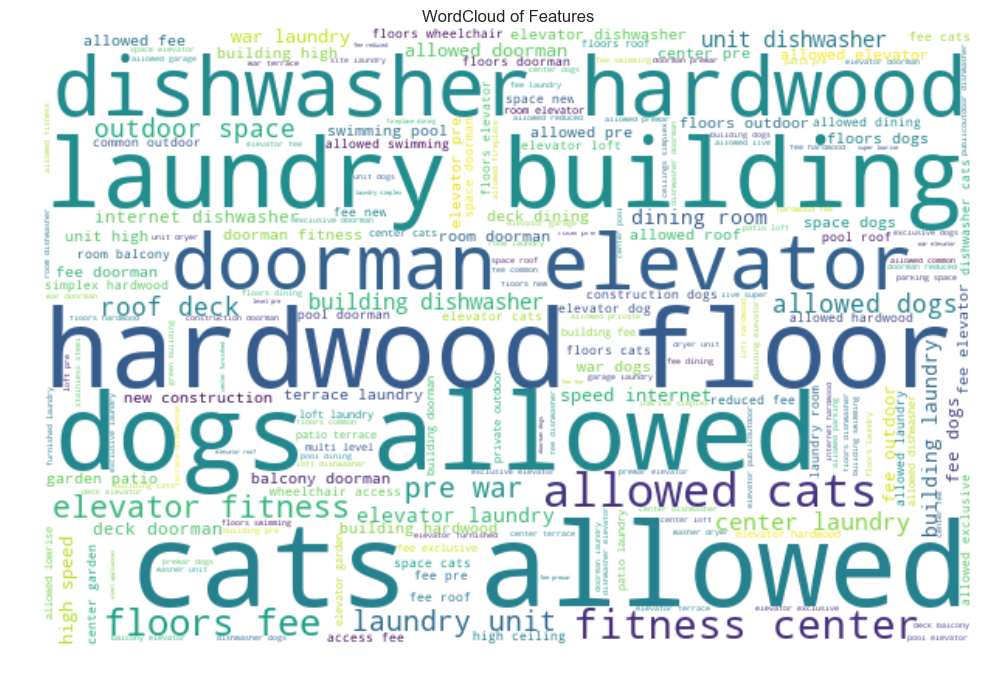

In [249]:
wordcloud = WordCloud(background_color='white', width=600, height=400).generate(' '.join(feature_arr))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Features')
plt.show()

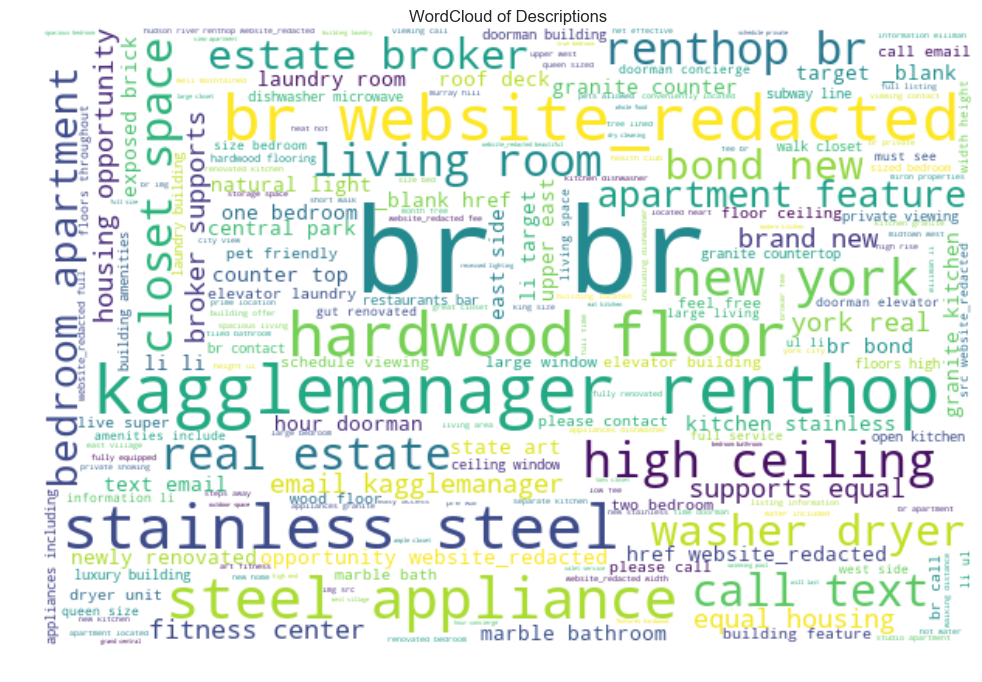

In [250]:
wordcloud = WordCloud(background_color='white', width=600, height=400).generate(' '.join(description_arr))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Descriptions')
plt.show()

Based on the the word clouds, we realise that many of the textual features are characteristics of an apartment that could be of significant interest to the renter. Therefore, we might be able to improve our predictions using the occurence of these words. Let's first use the `MultiLabelBinarizer` to break down the features array into multiple binary features.

In [251]:
# lets standardize the terms used in the feature labels
# remove '-' and make all lowercase 

train1.loc[:, 'features'] = train1['features'].apply(lambda list: [f.replace('-', ' ').lower() for f in list])

# extract features and their count
feature_dict = {}
for f in feature_arr:
    if f in feature_dict:
        feature_dict[f] = feature_dict[f] + 1 
    else: 
        feature_dict[f] = 1

# remove features that are rare to reduce noise
rare_features = []
for k,v in feature_dict.items():
    if v <= 5:
        rare_features.append(k)
        
def remove_rare(features):
    result = []
    for f in features:
        if f not in rare_features:
            result.append(f)
    return result

train1.loc[:, 'features'] = train1['features'].map(remove_rare)

In [252]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(train1['features'])

feature_columns = pd.DataFrame(mlb.transform(train1['features']))
feature_columns.columns = mlb.classes_
train1 = pd.concat([train1, feature_columns], axis=1)

In [253]:
# extract X and Y
y_train = train1['interest_level'].values
x_train = train1.drop(['interest_level', 'manager_id', 'building_id', 'created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "After adding feature labels")

===== After adding feature labels =====
Number of features = 10295

Accuracy: 0.7270294380017841
Log Loss: 1.854939878890926
Confusion Matrix:


,low,medium,high
low,5040,380,53
medium,1158,513,138
high,229,184,152


Report:
             precision    recall  f1-score   support

       high       0.44      0.27      0.33       565
        low       0.78      0.92      0.85      5473
     medium       0.48      0.28      0.36      1809

avg / total       0.69      0.73      0.70      7847



We found that adding features to our model improved the log loss score (1.96 to 1.85). This means that the model made lesser wrong predictions with high confidence - which is indicative of the predictive potential of the 'features' field.

Next, we move on to look at the description field. Since this field has free form text, we will extract the most common 2 and 3 ngrams present in the features column. This will yield us a list of phrasal features that we can extract and use as binary labels.

We will use a tunable `WORD_FREQ_THRESHOLD` that limits the ngrams generated to only the n most common phrases. After some experimentation, we found that 20 is the optimum value that gives the best improvement over the base model. 

In [254]:
import re
WORD_FREQ_THRESHOLD = 20
from sklearn.feature_extraction.text import CountVectorizer

# from our prior visualisation, we notice that there are alot of html tag fragments
# remove them to get cleaner results
tagsregex = re.compile('<.*?>')
def cleandesc(token):
    result = re.sub(tagsregex, '', token)
    return ''.join(i for i in result if not i.isdigit())

# we also remove stop words (the, this, them.. etc) since we are dealing with a natural language corpus
desc_3gram = CountVectorizer(input='content', strip_accents='ascii', analyzer='word',
                    ngram_range=(3,3), max_features=WORD_FREQ_THRESHOLD,
                    stop_words='english')
desc_2gram = CountVectorizer(input='content', strip_accents='ascii', analyzer='word',
                    ngram_range=(2,2), max_features=WORD_FREQ_THRESHOLD,
                    stop_words='english')

cleaned_descriptions = [cleandesc(x) for x in train1['description'].values]

desc_3gram.fit(cleaned_descriptions)
desc_2gram.fit(cleaned_descriptions)

desc_3gram.get_feature_names(), desc_2gram.get_feature_names()

(['appliances including dishwasher',
  'bond new york',
  'broker supports equal',
  'email kagglemanager renthop',
  'equal housing opportunity',
  'estate broker supports',
  'floor ceiling windows',
  'floors high ceilings',
  'granite counter tops',
  'hardwood floors high',
  'housing opportunity website_redacted',
  'kagglemanager renthop com',
  'kitchen stainless steel',
  'new york real',
  'real estate broker',
  'renthop com website_redacted',
  'stainless steel appliances',
  'supports equal housing',
  'washer dryer unit',
  'york real estate'],
 ['apartment features',
  'bedroom apartment',
  'brand new',
  'closet space',
  'com website_redacted',
  'email kagglemanager',
  'equal housing',
  'estate broker',
  'fitness center',
  'hardwood floors',
  'high ceilings',
  'kagglemanager renthop',
  'living room',
  'new york',
  'real estate',
  'renthop com',
  'stainless steel',
  'steel appliances',
  'washer dryer',
  'york real'])

In [255]:
# now, lets create new columns to encode the presence of these ngrams
desc = [cleandesc(x) for x in train1['description'].values]
desc_2gram_df = pd.DataFrame(desc_2gram.transform(desc).toarray())
desc_3gram_df = pd.DataFrame(desc_3gram.transform(desc).toarray())

train2 = pd.concat([train1, desc_2gram_df, desc_3gram_df], axis=1)

In [256]:
# extract X and Y
y_train = train2['interest_level'].values
x_train = train2.drop(['interest_level', 'manager_id', 'building_id', 'created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "After adding textual features")

===== After adding textual features =====
Number of features = 10335

Accuracy: 0.7220593857525169
Log Loss: 1.807821627098914
Confusion Matrix:


,low,medium,high
low,5043,389,41
medium,1174,505,130
high,277,170,118


Report:
             precision    recall  f1-score   support

       high       0.41      0.21      0.28       565
        low       0.78      0.92      0.84      5473
     medium       0.47      0.28      0.35      1809

avg / total       0.68      0.72      0.69      7847



Unfortunately, this version with ngrams from the descriptions actually performs worse than the previous one. We hypothesized that it was due to the fact that the ngrams we extracted programatically included some that had no semantic meaning, for example, we had "york real", or "renthop com website_redacted". Let's create a new `CountVectorizer` that reads from our custom dictionary, using **only** meaningful ngrams from the previous step.

In [257]:
# create new CountVectorizer with only meaningful ngrams
custom_vocab2 = CountVectorizer(input='content', strip_accents='ascii', analyzer='word',
                    ngram_range=(2,2), stop_words='english')
custom_vocab3 = CountVectorizer(input='content', strip_accents='ascii', analyzer='word',
                    ngram_range=(3,3), stop_words='english')
custom_vocab2.fit([
  'restaurants bar',
  'large window',
  'separate kitchen',
  'full service',
  'queen size',
  'fitness center',
  'hardwood floors',
  'high ceilings',
  'hot water',
  'bedroom apartment',
  'brand new',
  'central park',
  'closet space',
  'counter tops',
  'exposed brick',
  'fitness center',
  'granite counter',
  'granite kitchen',
  'high ceilings',
  'hour doorman',
  'kitchen stainless',
  'laundry room',
  'living room',
  'marble bathroom',
  'natural light',
  'new york',
  'newly renovated',
  'real estate',
  'roof deck',
  'stainless steel',
  'state art',
  'steel appliances',
  'washer dryer',
  'subway line',
  'short walk',
  'natural light',
  'pet friendly'
])

custom_vocab3.fit([
  'ample closet space',
  'appliances including dishwasher',
  'equal housing opportunity',
  'estate broker supports',
  'feel free contact',
  'granite counter tops',
  'great closet space',
  'hot water included',
  'information schedule viewing',
  'large living room',
  'new stainless steel',
  'spacious living room',
  'stainless steel appliances',
  'stainless steel kitchen',
  'state art fitness',
  'supports equal housing',
  'washer dryer unit',
])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(3, 3), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [258]:
# now, lets create new columns to encode the presence of these ngrams
desc = [cleandesc(x) for x in train1['description'].values]
custom_vocab2_df = pd.DataFrame(custom_vocab2.transform(desc).toarray())
custom_vocab2_df.columns = custom_vocab2.get_feature_names()
custom_vocab3_df = pd.DataFrame(custom_vocab3.transform(desc).toarray())
custom_vocab3_df.columns = custom_vocab3.get_feature_names()

train2 = pd.concat([train1, custom_vocab2_df, custom_vocab3_df], axis=1)

# extract X and Y
y_train = train2['interest_level'].values
x_train = train2.drop(['interest_level', 'manager_id', 'building_id', 'created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=27)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "After adding textual features (only meaningful ones)")

===== After adding textual features (only meaningful ones) =====
Number of features = 10345

Accuracy: 0.7229514464126418
Log Loss: 1.7728885636214404
Confusion Matrix:


,low,medium,high
low,5035,383,55
medium,1179,495,135
high,257,165,143


Report:
             precision    recall  f1-score   support

       high       0.43      0.25      0.32       565
        low       0.78      0.92      0.84      5473
     medium       0.47      0.27      0.35      1809

avg / total       0.68      0.72      0.69      7847



Selecting only semantically meaningful ngrams gave a marginal boost to our performance, improving our log loss from 1.80 to 1.77. However, the disadvantage of this approach is that it requires some manual selection (unless we are able to have natural language understanding). 

### Univariate Feature Selection

Now that we have included text features, we have more than 10k unique features included in our model. We will start pruning those features that perform poorly, using the `VarianceThreshold` and univariate feature selection techniques. 

With a lesser number of features, we can afford to increase the n_estimators argument of the `RandomForestClassifier`, which takes longer to execute (since it builds more trees) but significantly increases performance too.

In [259]:
from sklearn.feature_selection import *

# extract X and Y
y_train = train2['interest_level'].values
x_train = train2.drop(['interest_level', 'manager_id', 'building_id', 'created', 'description', 'display_address', 'features', 'listing_id', 'photos', 'street_address'], axis=1)

In [260]:
vt = VarianceThreshold(threshold=0)

# since chi2 only works on non-negative values
x_train.loc[:,'longitude'] = x_train['longitude'].apply(lambda x: -x if x < 0 else x)

# remove features that have low variance between samples
x_new = vt.fit_transform(x_train)

# use SelectPercentile to pick top performing features based on statistical tests (chi-squared, used for classification)
fit = SelectPercentile(chi2).fit(x_new, y_train)
x_new = fit.transform(x_new)

/Users/clarencenpy/miniconda3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [261]:
# split our train data into test and training set
X_train, X_test, Y_train, Y_test = train_test_split(x_new, y_train, test_size=0.2, random_state=27, stratify=y_train)

# Let's train our model using RandomForest
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
clf = clf.fit(X_train, Y_train)

evaluate(clf, X_test, Y_test, "Using only top performing features")

===== Using only top performing features =====
Number of features = 1034

Accuracy: 0.7165795845546069
Log Loss: 0.7432641346547213
Confusion Matrix:


,low,medium,high
low,5000,380,47
medium,1234,471,117
high,240,206,152


Report:
             precision    recall  f1-score   support

       high       0.48      0.25      0.33       598
        low       0.77      0.92      0.84      5427
     medium       0.45      0.26      0.33      1822

avg / total       0.67      0.72      0.68      7847



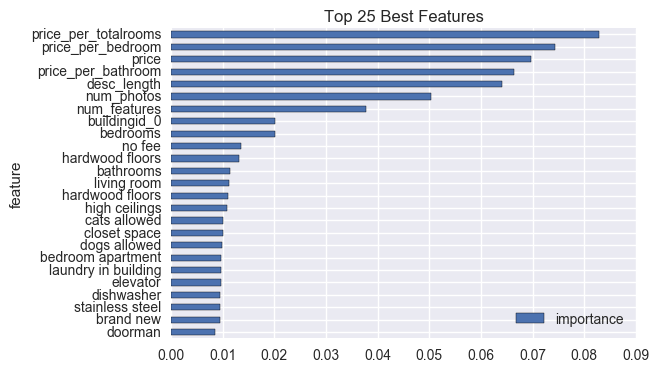

In [262]:
# plot the most important features by importance
selected_features = pd.DataFrame([x_train.columns, fit.get_support()], index=['feature', 'included']).T
selected_features = selected_features[selected_features['included'] == True]
selected_features = selected_features.assign(importance=clf.feature_importances_)
selected_features = selected_features.sort_values(by='importance', ascending=False)
selected_features = selected_features[:25]
selected_features.index = selected_features['feature']
selected_features.drop(['included', 'feature'], axis=1, inplace=True)
selected_features = selected_features.sort_values(by='importance')
selected_features.plot(kind='barh')
plt.title('Top 25 Best Features')
plt.show()

Now that we have completed building our final model, lets use cross validation to assess how well the model generalizes to other independent datasets. 

In [263]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(clf, x_train, y_train, cv=10, scoring='log_loss').mean()
print('Average Log Loss with Cross Validation = {}'.format(score))

/Users/clarencenpy/miniconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/clarencenpy/miniconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/clarencenpy/miniconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/clarencenpy/miniconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:127: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/clarencenpy/miniconda3/lib/python3.5/site-pac

Average Log Loss with Cross Validation = -0.7014462560918624


<center><h3>Analysis and Conclusions</h3></center>

After performing feature selection, we finally get to see the results of our hard work. Of particular learning value for us was looking at the which features performed the best, ordered by importance. Based on the plot of the top 25 features above, we note that derived features performed the best in general (which was also one of the lower hanging fruits that we did relatively easily). `buildingid_0` also featured on the top 25 list - which means that being located in a particular building turned out to be a strong predictor of interest level. Following those, the 'feature tags' were also good predictors of interest level. 

Unfortunately, the ngrams that we extracted from the listings' descriptions did not turn out to be useful features. One possible explanation for this is that the the description field is less accessible to users. Not all users would actually click into the listing and be able to read the description, and hence it has lesser of an effect on the interest level. This is in contrast to the 'features' or 'price' fields that are prominently displayed on the search results page, helping users gauge their decision.

Using 10-fold cross validation, we obtained an average log loss score that is close to our score without cross validation, which shows that our model is able to generalize well. 